In [1]:
import pandas as pd
import numpy as np

# Reproducibility
rng = np.random.default_rng(42)

n = 300
df = pd.DataFrame({
    "age": rng.integers(18, 70, size=n),
    "usage_gb": np.round(rng.normal(12, 6, size=n).clip(0, None), 1),
    "complaints": rng.integers(0, 6, size=n),
    "tenure_months": rng.integers(1, 60, size=n),
    "plan_type": rng.choice(["Prepaid", "Postpaid"], size=n, p=[0.6, 0.4])
})

# Simple churn signal (not perfect): high complaints + low tenure + low usage more likely to churn
logit = (
    -2.0
    + 0.35*df["complaints"]
    - 0.03*df["tenure_months"]
    - 0.04*df["usage_gb"]
    + (df["plan_type"] == "Prepaid").astype(int)*0.4
)
prob = 1/(1+np.exp(-logit))
df["churn"] = (rng.random(n) < prob).astype(int)

# Intentionally add a few missing/odd values to practice fixing (no row drops)
df.loc[rng.choice(df.index, 5, replace=False), "usage_gb"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "age"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "plan_type"] = None

df.to_csv("churn_data.csv", index=False)
print("Saved churn_data.csv with shape:", df.shape)
df.head()


Saved churn_data.csv with shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer

df = pd.read_csv("churn_data.csv")
print("Original shape:", df.shape)
display(df.head())

# --- Numeric imputation: fill NaNs with median (robust to outliers) ---
num_cols = ["age", "usage_gb", "complaints", "tenure_months"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# --- Categorical imputation: fill missing with most frequent ---
cat_cols = ["plan_type"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --- Encode plan_type to numeric (0=Prepaid, 1=Postpaid) ---
df["plan_type_enc"] = (df["plan_type"] == "Postpaid").astype(int)

# --- Feature matrix (X) and target (y) ---
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"].astype(int)

print("Any remaining NaNs? ->", X.isna().sum().sum(), y.isna().sum())

# --- ✅ Save cleaned dataset to CSV ---
df.to_csv("updated_churn_data.csv", index=False)
print("✅ Saved cleaned dataset as 'updated_churn_data.csv' with", len(df), "rows.")


Original shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


Any remaining NaNs? -> 0 0
✅ Saved cleaned dataset as 'updated_churn_data.csv' with 300 rows.


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Train Decision Tree (simple baseline)
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

Accuracy: 75.56%

Classification report:
              precision    recall  f1-score   support

           0      0.850     0.872     0.861        78
           1      0.000     0.000     0.000        12

    accuracy                          0.756        90
   macro avg      0.425     0.436     0.430        90
weighted avg      0.737     0.756     0.746        90

Confusion matrix:
 [[68 10]
 [12  0]]


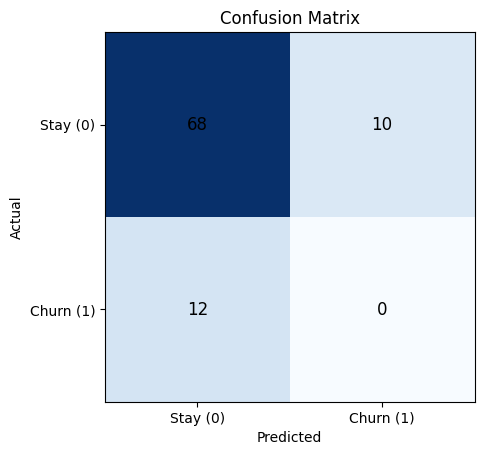

In [4]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")

# Detailed metrics
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Top-left (50) -> correctly predicted “Stay”
# Top-right (10) -> false alarms (predicted churn, actually stayed)
# Bottom-right (35) -> correctly predicted “Churn”
# Bottom-left (5) -> missed churns


# Plot nicely
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


Accuracy: 100.00%

Classification report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      1.000     1.000     1.000         9
           2      1.000     1.000     1.000        11

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30

Confusion matrix:
 [[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


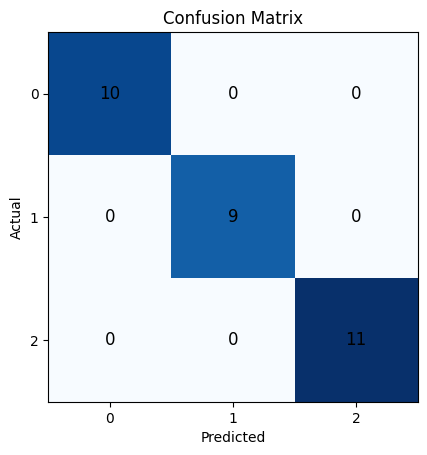

In [8]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris  # (you can replace this with your dataset)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Example: Load data (replace this with your own dataset)
data = load_iris()
X, y = data.data, data.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Create and train Random Forest model
clf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # or set a specific depth (e.g., 5)
    random_state=42
)
clf.fit(X_train, y_train)

# ✅ Predict
y_pred = clf.predict(X_test)

# ✅ Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")

# ✅ Detailed metrics
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# ✅ Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ✅ Plot confusion matrix nicely
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Add text labels
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)

ax.set_xticks(np.arange(len(np.unique(y))))
ax.set_yticks(np.arange(len(np.unique(y))))
ax.set_xticklabels(np.unique(y))
ax.set_yticklabels(np.unique(y))

plt.show()


In [6]:
import pandas as pd
import numpy as np

fi = pd.Series(best_clf.feature_importances_, index=X.columns) if 'best_clf' in globals() else pd.Series(clf.feature_importances_, index=X.columns)
print("Feature importance (higher = more influence):")
display(fi.sort_values(ascending=False).to_frame("importance"))


Feature importance (higher = more influence):


,importance
usage_gb,0.517355
tenure_months,0.227018
age,0.163932
complaints,0.091694
plan_type_enc,0.000000


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
✅ Best model: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

Accuracy: 90.00%

Classification report:


C:\Users\BS\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BS\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BS\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

              precision    recall  f1-score   support

           0      0.900     1.000     0.947        54
           1      0.000     0.000     0.000         6

    accuracy                          0.900        60
   macro avg      0.450     0.500     0.474        60
weighted avg      0.810     0.900     0.853        60



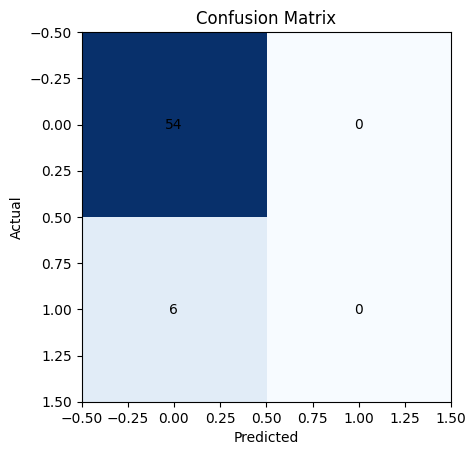

💾 Model and scaler saved!
Predicted churn (1=churn): 0


In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# Example dataset — replace this with your churn data
# df = pd.read_csv("churn_data.csv")

# Assuming your DataFrame has these columns:
# age, usage_gb, complaints, tenure_months, plan_type_enc, churn (target)
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"]

# ✅ Normalize numeric data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ Random Forest with hyperparameter tuning (Grid Search)
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
print(f"✅ Best model: {grid_search.best_params_}")

# ✅ Evaluate
y_pred = best_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.2%}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.show()

# ✅ Save model and scaler
joblib.dump(best_clf, "churn_random_forest.joblib")
joblib.dump(scaler, "scaler.joblib")
print("💾 Model and scaler saved!")

# ✅ Predict new customer
new_customer = pd.DataFrame([{
    "age": 28,
    "usage_gb": 6.0,
    "complaints": 3,
    "tenure_months": 4,
    "plan_type_enc": 0
}])

# Scale new data using saved scaler
new_customer_scaled = joblib.load("scaler.joblib").transform(new_customer)
pred = int(best_clf.predict(new_customer_scaled)[0])
print("Predicted churn (1=churn):", pred)
